In [2]:
import sqlite3
import pandas as pd
import plotly.express as px
import sys
import plotly.graph_objects as go

sys.path.append('../')
from functions_env import DB_PATH


conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()




In [3]:
data_proxies =  pd.read_sql_query("SELECT * FROM individual_wikipedia", conn)

,individual_wikidata_id,individual_name,wikipedia_page_url,language_code,links_ext_count,links_out_count,links_in_count,author,author_editcount,editors,minor_edits,revisions,pageviews,characters,references,unique_references,words,created_at,english_language_name,local_language_name
0,Q1000034,Joseph Dienger,https://sv.wikipedia.org/wiki/Joseph_Dienger,sv,8.0,18.0,0.0,Annika64,155879.0,3.0,2.0,5.0,0.0,461.0,0.0,0.0,65.0,2013-06-17,Swedish,Svenska
1,Q1000034,Joseph Dienger,https://de.wikipedia.org/wiki/Joseph_Dienger,de,21.0,22.0,6.0,Thiel1929,4901.0,19.0,14.0,29.0,5.0,2236.0,5.0,5.0,304.0,2006-09-27,German,Deutsch
2,Q100031,Kaspar von Stieler,https://sk.wikipedia.org/wiki/Kaspar_von_Stieler,sk,0.0,15.0,7.0,Kresadlo,7958.0,8.0,5.0,9.0,3.0,240.0,0.0,0.0,33.0,2007-02-02,Slovak,Slovenčina
3,Q100031,Kaspar von Stieler,https://ca.wikipedia.org/wiki/Kaspar_von_Stieler,ca,20.0,19.0,3.0,Jey,59236.0,8.0,11.0,20.0,4.0,543.0,1.0,1.0,80.0,2016-01-19,Catalan,Català
4,Q100031,Kaspar von Stieler,https://eo.wikipedia.org/wiki/Kaspar_von_Stieler,eo,10.0,44.0,9.0,Unukorno,7693.0,18.0,18.0,32.0,7.0,454.0,0.0,0.0,71.0,2003-06-29,Esperanto,Esperanto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699014,Q999920,Joseph Lange,https://fr.wikipedia.org/wiki/Joseph_Lange,fr,30.0,36.0,14.0,Fagairolles 34,74562.0,22.0,11.0,35.0,103.0,2939.0,15.0,15.0,476.0,2012-12-23,French,Français
699015,Q999920,Joseph Lange,https://es.wikipedia.org/wiki/Joseph_Lange,es,15.0,29.0,14.0,Jonathansasuga,2618.0,18.0,15.0,26.0,88.0,2990.0,15.0,15.0,498.0,2015-05-31,Spanish,Español
699016,Q999920,Joseph Lange,https://de.wikipedia.org/wiki/Joseph_Lange_(Sc...,de,16.0,32.0,30.0,Funkhauser,3698.0,35.0,18.0,52.0,90.0,1630.0,2.0,2.0,240.0,2007-01-12,German,Deutsch
699017,Q999920,Joseph Lange,https://sv.wikipedia.org/wiki/Joseph_Lange,sv,1.0,11.0,19.0,Rex Sueciæ,48057.0,3.0,1.0,3.0,2.0,583.0,1.0,1.0,86.0,2013-05-15,Swedish,Svenska


In [26]:
df = data_proxies[['individual_wikidata_id', 'english_language_name']]
df = df.dropna()

top_lang = df.english_language_name.value_counts()
top_lang =top_lang.head(25).index

df = df[df['english_language_name'].isin(top_lang)]

In [27]:
df_regions = pd.read_sql_query("SELECT * FROM individuals_regions", conn)

region_name = 'Low countries'

df_region_fil = df_regions[df_regions['region_name']==region_name]
df_region_fil = df_region_fil[['individual_wikidata_id', 'region_name']].copy()

df_final = pd.merge(df_region_fil, df, on = 'individual_wikidata_id')

df_year = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_year['productive_year'] = df_year['birthyear'] + 35
df_year = df_year[['individual_wikidata_id', 'productive_year']]
df_year = df_year.dropna()
df_year['decade'] = df_year['productive_year'].apply(lambda x: round(x / 10) * 10)

df_final = pd.merge(df_year, df_final, on = 'individual_wikidata_id')


In [30]:
df_group = df_final.groupby(['decade', 'english_language_name'])['individual_wikidata_id'].count().reset_index()


min_year = 1200
max_year = 1800

df_group = df_group[df_group['decade']>=min_year]
df_group = df_group[df_group['decade']<=max_year]

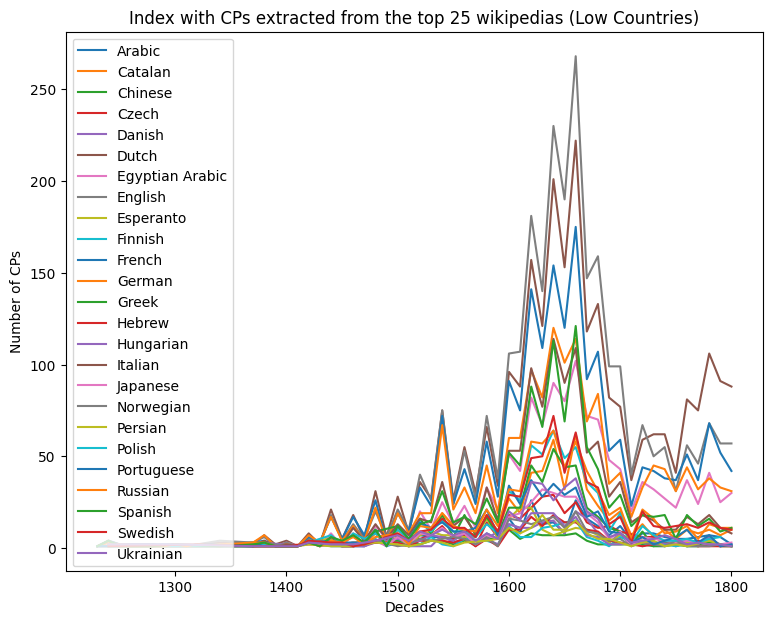

In [36]:
import matplotlib.pyplot as plt


# Plot a line for each creation year category
plt.figure(figsize=(9, 7))

for var, group in df_group.groupby('english_language_name'):
    plt.plot(group['decade'], group['individual_wikidata_id'], label=f'{var}')

plt.title('Index with CPs extracted from the top 25 wikipedias (Low Countries)')
plt.xlabel('Decades')
plt.ylabel('Number of CPs')
plt.legend()
plt.grid(False)

plt.savefig('figures/wikipedia_stats/index_per_wiki.png', dpi = 200)
plt.show()

In [38]:
df_corr = df_group.pivot(index = "decade", columns = "english_language_name", values = 'individual_wikidata_id')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()

0.8957586978110208

In [33]:
df_corr = df_group.pivot(index = "decade", columns = "creation_year", values = 'individual_wikidata_id')
df_corr = df_corr.fillna(0)
df_corr.corr().stack().mean()

0.8447044549525561